# <span style='color:blue'> Evaluation of ML classifiers after Hyperparameter optimization</span>

The present `Jupyter Notebook` contains the statistical assessment of the classifiers generated for activity class prediction of the BTZs under study.   

## Import Essentials

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster import hierarchy

In [2]:
# Import functions from customized modules
from pathlib import Path
import sys

PROJECT_DIR = list(Path("..").absolute().parents)[0]
sys.path.append(str(PROJECT_DIR) + '/Scripts/')

from preprocessing import create_mol, feature_filt, preprocessing
from classification import model_eval, create_model, model_stats

## Define file names and colors

In [3]:
# File names and sheet names
descriptors_file = './Data/BTZs_full_descriptors_final.xlsx'
data_matrix = 'general_data_matrix'
desc = 'descriptors'

# Define files for retrieving info from
hyperparam_desc = ['./Results/result_rd_rf.csv', 
                   './Results/result_rd_knn.csv',
                   './Results/result_rd_svm.csv',
                   './Results/result_rd_ada.csv']

# Repeat for Morgan fingerprints
hyperparam_morgan = ['./Results/result_rd_rf_morgan.csv', 
                     './Results/result_rd_knn_morgan.csv',
                     './Results/result_rd_svm_morgan.csv',
                     './Results/result_rd_ada_morgan.csv']

# Repeat for rdkit fingerprints
hyperparam_rdkit = ['./Results/result_rd_rf_rdkit.csv', 
                    './Results/result_rd_knn_rdkit.csv',
                    './Results/result_rd_svm_rdkit.csv',
                    './Results/result_rd_ada_rdkit.csv']


In [4]:
# Define colors (Color Brewer)
colors1 = ['#a6cee3', '#1f78b4', '#b2df8a']
colors2 = ['#ca0020', '#f4a582', '#92c5de', '#0571b0']

# Define a customized colormap 
cmap = LinearSegmentedColormap.from_list('', colors1)

## Load and prepare data  

#### Descriptors

The descriptors set was obtained using the Schrödinger Suite. 

In [5]:
# Load data set with SMILES
BTZs = pd.read_excel(descriptors_file, sheet_name=data_matrix)

# Load set of descriptors 
desc = pd.read_excel(descriptors_file, sheet_name=desc)

In [6]:
BTZs.shape

(96, 7)

In [7]:
# Check coincidence between dataframes
for i, j in zip(BTZs.iloc[:, 0], desc.iloc[:, 0]):
    if i != j:
        print('Error')

#### Calculate Fingerprints

Here a locally created function using RDKit is employed.

In [8]:
# Start from the Smiles string stored in BTZs dataframe
BTZs_morgan = BTZs.copy()
# Apply create_mol
create_mol(BTZs_morgan, 'ecfp4', n_bits=2048)

In [9]:
# Start from the Smiles string stored in BTZs dataframe
BTZs_rdkit = BTZs.copy()
# Apply create_mol --> add columns to the dataframe with mol and fp
create_mol(BTZs_rdkit, 'rdk5', n_bits=2048)

#### Prepare data sets

In [10]:
# Create X data sets from descriptors and molecular fingerprints
Xdesc = desc.iloc[:, 1:] 
print('X descriptors shape {}'.format(Xdesc.shape))

Xmorg = pd.DataFrame(BTZs_morgan.np_bv.to_list(), index=BTZs_morgan.index)
print('X Morgan shape {}'.format(Xmorg.shape))

Xrdk = pd.DataFrame(BTZs_rdkit.np_bv.to_list(), index=BTZs_rdkit.index)
print('X RDKit shape {}'.format(Xrdk.shape))

X descriptors shape (96, 227)
X Morgan shape (96, 2048)
X RDKit shape (96, 2048)


In [11]:
y = BTZs.Class

print('y shape {}'.format(y.shape))

y shape (96,)


## Model evaluation

Three different random seeds were used for splitting the data set into training and test set and training the models.

In [12]:
# Define a list of random seeds
seed = [57, 31, 86]

The four selected algorithms are used in subsequent calculations: Random Forest, Support Vector Machines, K-Nearest Neighbohrs, and AdaBoost. The models are instantiated using the best group of hyperparameters found by randomized search (SciKit-Learn) as retrieved below. 

In [13]:
# Build and evaluate the models using molecular descriptors
stats_desc = model_stats(hyperparam_desc, seed, Xdesc, y, 'filter')

In [14]:
stats_desc

,AUC_cv,BA_cv,f1_cv,MCC_cv,AUC_t,BA_t,f1_t,MCC_t,algorithm,seed
0,0.832474,0.752639,0.783236,0.525386,0.907143,0.842857,0.818182,0.676123,rf,57
1,0.855529,0.812996,0.823209,0.638320,0.850000,0.878571,0.857143,0.749159,knn,57
2,0.816647,0.752758,0.802573,0.535479,0.921429,0.785714,0.769231,0.597614,svm,57
3,0.832407,0.778591,0.804207,0.578503,0.907143,0.842857,0.818182,0.676123,ada,57
4,0.874783,0.822143,0.838960,0.657314,0.843750,0.833333,0.846154,0.676123,rf,31
5,0.866165,0.811786,0.809618,0.633330,0.819444,0.708333,0.695652,0.418121,knn,31
6,0.874447,0.791488,0.803370,0.593979,0.819444,0.791667,0.782609,0.585369,svm,31
7,0.865663,0.802679,0.819413,0.617642,0.826389,0.791667,0.814815,0.602464,ada,31
8,0.759306,0.707083,0.750115,0.425710,0.900000,0.788889,0.736842,0.567367,rf,86
9,0.848866,0.792778,0.825459,0.594602,0.962963,0.844444,0.800000,0.669342,knn,86


In [15]:
# Build and evaluate the models using Morgan fingerprints
stats_morg = model_stats(hyperparam_morgan, seed, Xmorg, y, 'split')

In [16]:
stats_morg

,AUC_cv,BA_cv,f1_cv,MCC_cv,AUC_t,BA_t,f1_t,MCC_t,algorithm,seed
0,0.864044,0.772758,0.836480,0.595043,0.885714,0.700000,0.692308,0.418330,rf,57
1,0.757877,0.757877,0.774656,0.525263,0.771429,0.771429,0.750000,0.542857,knn,57
2,0.864643,0.799147,0.823764,0.614336,0.828571,0.807143,0.782609,0.607808,svm,57
3,0.855218,0.795317,0.818813,0.604972,0.792857,0.735714,0.720000,0.480079,ada,57
4,0.831922,0.759226,0.776396,0.530550,0.829861,0.750000,0.750000,0.500000,rf,31
5,0.825889,0.783333,0.768137,0.583004,0.812500,0.708333,0.695652,0.418121,knn,31
6,0.883605,0.783690,0.806248,0.582042,0.791667,0.750000,0.750000,0.500000,svm,31
7,0.842164,0.790536,0.800257,0.592752,0.777778,0.708333,0.695652,0.418121,ada,31
8,0.794491,0.682083,0.784179,0.421166,0.888889,0.800000,0.750000,0.600000,rf,86
9,0.772130,0.705833,0.785987,0.446221,0.874074,0.744444,0.695652,0.480079,knn,86


In [17]:
# Build and evaluate the models using RDKit fingerprints
stats_rdk = model_stats(hyperparam_rdkit, seed, Xrdk, y, 'split')

C:\Users\FBernal\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\FBernal\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\FBernal\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\FBernal\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\FBernal\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_s

In [18]:
stats_rdk

,AUC_cv,BA_cv,f1_cv,MCC_cv,AUC_t,BA_t,f1_t,MCC_t,algorithm,seed
0,0.802407,0.738333,0.799635,0.518151,0.821429,0.700000,0.692308,0.418330,rf,57
1,0.777917,0.701786,0.800585,0.481998,0.750000,0.628571,0.642857,0.292770,knn,57
2,0.819960,0.759643,0.836702,0.592023,0.771429,0.664286,0.666667,0.356386,svm,57
3,0.825529,0.769405,0.811362,0.569872,0.832143,0.735714,0.720000,0.480079,ada,57
4,0.706798,0.714762,0.763562,0.455750,0.715278,0.583333,0.666667,0.192450,rf,31
5,0.797789,0.681786,0.751990,0.403540,0.798611,0.666667,0.733333,0.384900,knn,31
6,0.766293,0.717679,0.778803,0.474043,0.840278,0.625000,0.709677,0.307794,svm,31
7,0.780357,0.703512,0.766681,0.444322,0.819444,0.666667,0.714286,0.353553,ada,31
8,0.797384,0.752222,0.810788,0.535154,0.844444,0.688889,0.636364,0.367058,rf,86
9,0.762870,0.642639,0.778047,0.368646,0.740741,0.700000,0.666667,0.447214,knn,86


In [21]:
# Finally, combine all the results together
stats_whole = pd.concat((stats_desc, stats_morg, stats_rdk), axis=0)
# Add a column for data type used for model generation
stats_whole['data'] = ['desc'] * 12 + ['morgan'] * 12 + ['rdkit'] * 12
# Add a column for name of model
stats_whole['Model'] = ['M{}'.format(x) for x in range(1, len(stats_whole) + 1)]
# Rearrange columns to have names in first place
cols = stats_whole.columns.tolist()
cols = cols[-1:] + cols[:-1]
stats_whole = stats_whole[cols]

In [21]:
stats_whole.shape

(36, 12)

## Principal Component Analysis over statistical results

In [23]:
# Now for the overall dataset

# Scale data
scaler = StandardScaler()
data = stats_whole.iloc[:, 1:9].copy()
data_sc = scaler.fit_transform(data)
data_sc = pd.DataFrame(data_sc, columns=data.columns)

In [24]:
# pca using a random seed for reproducibility
pca = PCA(random_state=21)

pca.fit(data_sc)
X_pca_stat = pca.transform(data_sc)
pca_var = pca.explained_variance_ratio_
print('Explained variance of first three Principal Components (%)')
print([np.round(x * 100, 2) for x in pca_var[:3]])

Explained variance of first three Principal Components (%)
[59.89, 22.87, 9.29]


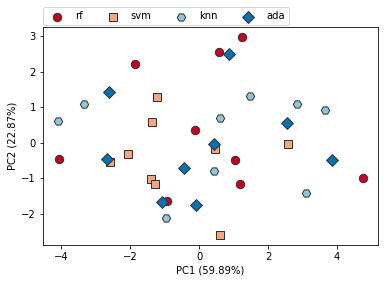

In [25]:
# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

# Add axes object to our figure 
ax = fig.add_subplot(111)

# Add scatter plot colored by algorithm
for i, (lab, m) in enumerate(zip(['rf', 'svm', 'knn', 'ada'], ['o', 's', 'H', 'D'])):
    ax.scatter(X_pca_stat[stats_whole.algorithm == lab, 0], X_pca_stat[stats_whole.algorithm == lab, 1],  
               c=colors2[i], marker=m, s=70, edgecolors=[0.2, 0.2, 0.2], label=lab)


# Edit axes
ax.set_xlabel('PC1 ({}%)'.format(np.round(pca_var[0] * 100, 2)))
ax.set_ylabel('PC2 ({}%)'.format(np.round(pca_var[1] * 100, 2)))

ax.legend(loc=(0, 1.01), ncol=4)

plt.show()

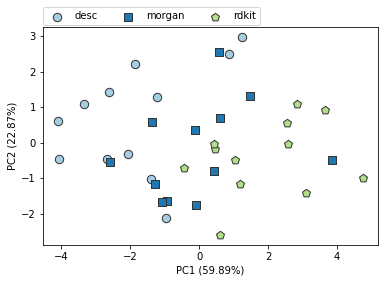

In [26]:
# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

# Add axes object to our figure 
ax = fig.add_subplot(111)

# Add scatter plot for each type of data set
for i, (lab, m) in enumerate(zip(['desc', 'morgan', 'rdkit'], ['o', 's', 'p'])):
    ax.scatter(X_pca_stat[stats_whole.data == lab, 0], X_pca_stat[stats_whole.data == lab, 1],  
               c=colors1[i], marker=m, s=70, edgecolors=[0.2, 0.2, 0.2], label=lab)


# Edit axes
ax.set_xlabel('PC1 ({}%)'.format(np.round(pca_var[0] * 100, 2)))
ax.set_ylabel('PC2 ({}%)'.format(np.round(pca_var[1] * 100, 2)))

ax.legend(loc=(0, 1.01), ncol=3)

plt.show()

<Figure size 432x288 with 0 Axes>

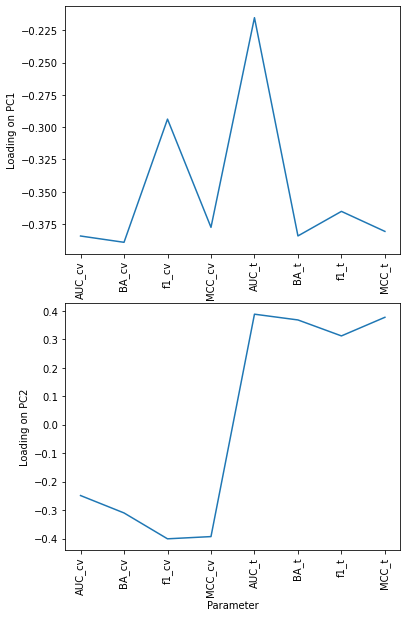

In [27]:
# Define PCA coefficients
coeff = np.transpose(pca.components_[0:2, :])

x = np.arange(len(coeff))

# Plot loadings for PC1 and PC2
plt.figure()
fig, axs = plt.subplots(2,1, figsize=(6, 10))
for i in [0, 1]:
    axs[i].plot(x, coeff[:, i])
    axs[i].set_xlabel('Parameter')
    axs[i].set_ylabel('Loading on PC{}'.format(i + 1))
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(data.columns, rotation=90)

plt.show()

<Figure size 432x288 with 0 Axes>

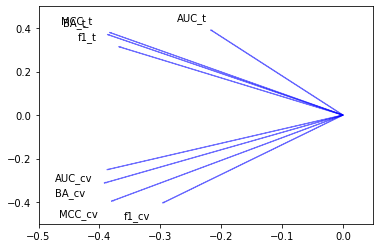

In [28]:
# Plot PCA loadings in PC1-PC2 space 
plt.figure()
fig, ax = plt.subplots()
for i in range(coeff.shape[0]):
    ax.arrow(0, 0, coeff[i,0], coeff[i,1], color='b', alpha = 0.5)
    ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, data.columns[i], ha = 'center', va = 'center')
    ax.set_xlim(-0.5, 0.05)
    ax.set_ylim(-0.5, 0.5)
    
plt.show()

In [29]:
# Create loading matrix for all the PC's
lm = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(lm, 
                              columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'], 
                              index=data.columns)
loading_matrix

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
AUC_cv,-0.852908,-0.341622,-0.059900,-0.123154,-0.406002,-0.028573,-0.002106,-0.000099
BA_cv,-0.863740,-0.425530,-0.119748,-0.214050,0.193133,-0.045114,-0.040713,0.017315
f1_cv,-0.652102,-0.550280,0.397387,0.366532,0.008752,0.089273,-0.014639,0.002066
MCC_cv,-0.838048,-0.539533,-0.022991,-0.091196,0.150865,-0.020988,0.053138,-0.016752
AUC_t,-0.477845,0.532816,0.676554,-0.238025,0.009927,0.043076,0.002731,0.000076
BA_t,-0.852781,0.505062,-0.066808,0.125152,0.032792,-0.153596,-0.027829,-0.026088
f1_t,-0.810611,0.428090,-0.344021,-0.008932,0.016210,0.263626,-0.003133,-0.004244
MCC_t,-0.844989,0.517861,-0.086152,0.167559,0.001750,-0.095370,0.031884,0.027778


#### HCA on the whole set of models

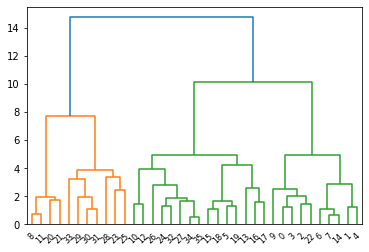

In [30]:
# Generate a dendrogram to analyze general behavior 
Zw = hierarchy.linkage(data_sc, 'ward')
fig = plt.figure()
dn_w = hierarchy.dendrogram(Zw)

As can be seen, three clusters a reasonable choice

In [31]:
clust3 = AgglomerativeClustering(n_clusters=3).fit(data_sc)

<Figure size 432x288 with 0 Axes>

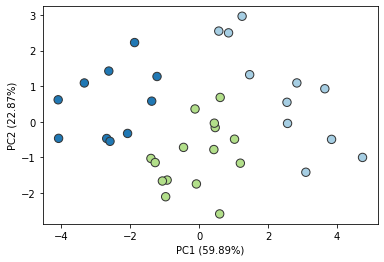

In [32]:
# PCA score plot grouping by HCA clusters
plt.figure()
fig, ax = plt.subplots()
ax.scatter(X_pca_stat[:, 0], X_pca_stat[:, 1], c=clust3.labels_, 
           cmap=cmap, s=70, edgecolors=[0.2, 0.2, 0.2])

# Add labels
# for i in range(len(X_pca_w)):
#     ax.text(X_pca_stat[i, 0], X_pca_stat[i, 1], stats_whole.algorithm.values[i][0] + str(stats_whole.seed.values[i]) + 
#            stats_whole.data.values[i][0])

# Edit axes
ax.set_xlabel('PC1 ({}%)'.format(np.round(pca_var[0] * 100, 2)))
ax.set_ylabel('PC2 ({}%)'.format(np.round(pca_var[1] * 100, 2)))

plt.show()

## Model Scoring - Method 1

In [33]:
# Comparing models based on mean value for CV and external validation
red1 = pd.concat((data.iloc[:, :3], (data.iloc[:,3] + 1) / 2), axis=1)
red1.columns = red1.columns.tolist()[:3] + ['nMCC_cv']
red2 = pd.concat((data.iloc[:, 4:7], (data.iloc[:,7] + 1) / 2), axis=1)
red2.columns = red2.columns.tolist()[:3] + ['nMCC_t']

stats_red = pd.concat((red1.mean(axis=1), red2.mean(axis=1)), axis=1)

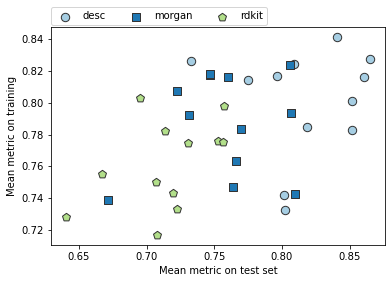

In [34]:
# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

# Add axes object to our figure 
ax = fig.add_subplot(111)

# Create scatter plot for each data type
for i, (lab, m) in enumerate(zip(['desc', 'morgan', 'rdkit'], ['o', 's', 'p'])):
    ax.scatter(stats_red[stats_whole.data == lab].iloc[:, 1], stats_red[stats_whole.data == lab].iloc[:, 0],  
               c=colors1[i], marker=m, s=70, edgecolors=[0.2, 0.2, 0.2], label=lab)

# Edit axes
ax.set_xlabel('Mean metric on test set')
ax.set_ylabel('Mean metric on training')

# Add legend
ax.legend(loc=(0, 1.01), ncol=3)

plt.show()

In [35]:
# Compare mean value over all the statistical parameters including both cross-validation and external validation
best_mean = pd.DataFrame(columns=['mean'])
best_mean['mean'] = pd.concat((red1, red2), axis=1).mean(axis=1)
best_mean = pd.concat((stats_whole.iloc[:, 0], best_mean, stats_whole.iloc[:, 9:]), axis=1)
best_mean.sort_values(by='mean', inplace=True, ascending=False)
best_mean

,Model,mean,algorithm,seed,data
1,M2,0.846398,knn,57,desc
4,M5,0.840730,rf,31,desc
9,M10,0.838310,knn,86,desc
3,M4,0.826338,ada,57,desc
0,M1,0.817161,rf,57,desc
7,M8,0.816335,ada,31,desc
2,M15,0.814619,svm,57,morgan
6,M7,0.806587,svm,31,desc
2,M3,0.801862,svm,57,desc
10,M23,0.799916,svm,86,morgan


## Model Scoring - Method 2

In [36]:
# Trial using a scoring to summarize all the statistics

# Scheme to try:
# If value > 0.8 --> 2 points
# If value only > 0.75 --> 1 point
# If value < 0.65 --> - 1 point

def score(x):
    if x >= 0.8:
        s = 2
    elif (x >= 0.75) & (x < 0.8):
        s = 1
    elif x < 0.65:
        s = -1
    else:
        s = 0
        
    return s

In [41]:
# Score the set of models
stats_for_scoring = pd.concat((red1, red2), axis=1)

scores = []
for idx, row in stats_for_scoring.iterrows():
    s = sum([score(x) for x in row])
    scores.append(s)
    
scoring = stats_whole.copy()
scoring['score'] = scores
scoring

,Model,AUC_cv,BA_cv,f1_cv,MCC_cv,AUC_t,BA_t,f1_t,MCC_t,algorithm,seed,data,score
0,M1,0.832474,0.752639,0.783236,0.525386,0.907143,0.842857,0.818182,0.676123,rf,57,desc,13
1,M2,0.855529,0.812996,0.823209,0.638320,0.850000,0.878571,0.857143,0.749159,knn,57,desc,16
2,M3,0.816647,0.752758,0.802573,0.535479,0.921429,0.785714,0.769231,0.597614,svm,57,desc,11
3,M4,0.832407,0.778591,0.804207,0.578503,0.907143,0.842857,0.818182,0.676123,ada,57,desc,14
4,M5,0.874783,0.822143,0.838960,0.657314,0.843750,0.833333,0.846154,0.676123,rf,31,desc,16
5,M6,0.866165,0.811786,0.809618,0.633330,0.819444,0.708333,0.695652,0.418121,knn,31,desc,10
6,M7,0.874447,0.791488,0.803370,0.593979,0.819444,0.791667,0.782609,0.585369,svm,31,desc,11
7,M8,0.865663,0.802679,0.819413,0.617642,0.826389,0.791667,0.814815,0.602464,ada,31,desc,15
8,M9,0.759306,0.707083,0.750115,0.425710,0.900000,0.788889,0.736842,0.567367,rf,86,desc,6
9,M10,0.848866,0.792778,0.825459,0.594602,0.962963,0.844444,0.800000,0.669342,knn,86,desc,13


In [42]:
scoring[scoring.score > 9]

,Model,AUC_cv,BA_cv,f1_cv,MCC_cv,AUC_t,BA_t,f1_t,MCC_t,algorithm,seed,data,score
0,M1,0.832474,0.752639,0.783236,0.525386,0.907143,0.842857,0.818182,0.676123,rf,57,desc,13
1,M2,0.855529,0.812996,0.823209,0.638320,0.850000,0.878571,0.857143,0.749159,knn,57,desc,16
2,M3,0.816647,0.752758,0.802573,0.535479,0.921429,0.785714,0.769231,0.597614,svm,57,desc,11
3,M4,0.832407,0.778591,0.804207,0.578503,0.907143,0.842857,0.818182,0.676123,ada,57,desc,14
4,M5,0.874783,0.822143,0.838960,0.657314,0.843750,0.833333,0.846154,0.676123,rf,31,desc,16
5,M6,0.866165,0.811786,0.809618,0.633330,0.819444,0.708333,0.695652,0.418121,knn,31,desc,10
6,M7,0.874447,0.791488,0.803370,0.593979,0.819444,0.791667,0.782609,0.585369,svm,31,desc,11
7,M8,0.865663,0.802679,0.819413,0.617642,0.826389,0.791667,0.814815,0.602464,ada,31,desc,15
9,M10,0.848866,0.792778,0.825459,0.594602,0.962963,0.844444,0.800000,0.669342,knn,86,desc,13
2,M15,0.864643,0.799147,0.823764,0.614336,0.828571,0.807143,0.782609,0.607808,svm,57,morgan,14


Evidently, both approaches (mean over all the statistics and scoring) are providing comparable results, demonstrating overall better performance by the descriptors-based models. The best models are obtained with seed 57 and 31, the former giving always better predictions (the latter provides more robust models during CV).

In [43]:
scoring[scoring.score >= 11]

,Model,AUC_cv,BA_cv,f1_cv,MCC_cv,AUC_t,BA_t,f1_t,MCC_t,algorithm,seed,data,score
0,M1,0.832474,0.752639,0.783236,0.525386,0.907143,0.842857,0.818182,0.676123,rf,57,desc,13
1,M2,0.855529,0.812996,0.823209,0.638320,0.850000,0.878571,0.857143,0.749159,knn,57,desc,16
2,M3,0.816647,0.752758,0.802573,0.535479,0.921429,0.785714,0.769231,0.597614,svm,57,desc,11
3,M4,0.832407,0.778591,0.804207,0.578503,0.907143,0.842857,0.818182,0.676123,ada,57,desc,14
4,M5,0.874783,0.822143,0.838960,0.657314,0.843750,0.833333,0.846154,0.676123,rf,31,desc,16
6,M7,0.874447,0.791488,0.803370,0.593979,0.819444,0.791667,0.782609,0.585369,svm,31,desc,11
7,M8,0.865663,0.802679,0.819413,0.617642,0.826389,0.791667,0.814815,0.602464,ada,31,desc,15
9,M10,0.848866,0.792778,0.825459,0.594602,0.962963,0.844444,0.800000,0.669342,knn,86,desc,13
2,M15,0.864643,0.799147,0.823764,0.614336,0.828571,0.807143,0.782609,0.607808,svm,57,morgan,14
10,M23,0.820509,0.768194,0.806474,0.556105,0.851852,0.811111,0.761905,0.602464,svm,86,morgan,13


In [44]:
scoring[(scoring.score > 9) & (scoring.seed == 57)]

,Model,AUC_cv,BA_cv,f1_cv,MCC_cv,AUC_t,BA_t,f1_t,MCC_t,algorithm,seed,data,score
0,M1,0.832474,0.752639,0.783236,0.525386,0.907143,0.842857,0.818182,0.676123,rf,57,desc,13
1,M2,0.855529,0.812996,0.823209,0.638320,0.850000,0.878571,0.857143,0.749159,knn,57,desc,16
2,M3,0.816647,0.752758,0.802573,0.535479,0.921429,0.785714,0.769231,0.597614,svm,57,desc,11
3,M4,0.832407,0.778591,0.804207,0.578503,0.907143,0.842857,0.818182,0.676123,ada,57,desc,14
2,M15,0.864643,0.799147,0.823764,0.614336,0.828571,0.807143,0.782609,0.607808,svm,57,morgan,14


In [45]:
scoring[(scoring.score > 9) & (scoring.seed == 31)]

,Model,AUC_cv,BA_cv,f1_cv,MCC_cv,AUC_t,BA_t,f1_t,MCC_t,algorithm,seed,data,score
4,M5,0.874783,0.822143,0.838960,0.657314,0.843750,0.833333,0.846154,0.676123,rf,31,desc,16
5,M6,0.866165,0.811786,0.809618,0.633330,0.819444,0.708333,0.695652,0.418121,knn,31,desc,10
6,M7,0.874447,0.791488,0.803370,0.593979,0.819444,0.791667,0.782609,0.585369,svm,31,desc,11
7,M8,0.865663,0.802679,0.819413,0.617642,0.826389,0.791667,0.814815,0.602464,ada,31,desc,15
4,M17,0.831922,0.759226,0.776396,0.530550,0.829861,0.750000,0.750000,0.500000,rf,31,morgan,10
6,M19,0.883605,0.783690,0.806248,0.582042,0.791667,0.750000,0.750000,0.500000,svm,31,morgan,10


In [46]:
scoring.to_csv('./Results/Statistics_ML_models.csv', index=False)